In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
%%html
<style>
.cell-output-ipywidget-background {
    background-color: transparent !important;
}
:root {
    --jp-widgets-color: var(--vscode-editor-foreground);
    --jp-widgets-font-size: var(--vscode-editor-font-size);
}  
</style>

In [3]:
from itertools import islice
from lib import models
from lib.nyt_connections import get_connections_games, get_connections_tasks
from lib.pack import packed_tensors_from_tokenized_results, plot_packed_tensors
from lib.recipe import ComponentConfig, TuneRecipeConfig
from lib.tasks import ChatCompletionParams, get_task_results
from lib.tokenize import TaskResultTokenizer
from lib.tune import tune
from lib.vllm import start_vllm, kill_vllm_workers
import openai
import os
import torch
from transformers import AutoTokenizer

games = get_connections_games()
tasks = list(
    islice(get_connections_tasks(games, parse_answers_liberally=False), len(games) * 2)
)
# distill_tasks = tasks[:436]
distill_tasks = tasks[:256]
val_tasks = tasks[436:508]
test_tasks = tasks[508 : len(games)]
train_tasks = tasks[len(games) : len(games) + 436]
len(distill_tasks), len(val_tasks), len(test_tasks), len(train_tasks)

(256, 72, 92, 436)

In [6]:
model = models.qwen_7b
base_model = model.base_model
# tokenizer = AutoTokenizer.from_pretrained(base_model)
tokenizer = AutoTokenizer.from_pretrained("deepseek-ai/DeepSeek-R1-Distill-Llama-70B")

distill_client = openai.AsyncOpenAI(
    base_url="https://api.fireworks.ai/inference/v1",
    api_key=os.getenv("FIREWORKS_API_KEY"),
)
distill_model = "accounts/fireworks/models/deepseek-r1"

tokenized_results = [
    result
    for results in await get_task_results(
        tasks=distill_tasks,
        client=distill_client,
        model=distill_model,
        params=ChatCompletionParams(
            max_tokens=2**17,
            logprobs=True,
            top_logprobs=5,
        ),
        transform=TaskResultTokenizer(tokenizer),
    )
    for result in results
]
print(
    "Max sequence length:",
    max(len(tokenized_result.token_ids) for tokenized_result in tokenized_results),
)
print(
    "Number of results with no logprobs:",
    sum(
        1
        for tokenized_result in tokenized_results
        if tokenized_result.token_logprobs is None
    ),
)

tokenizer_config.json:   0%|          | 0.00/3.07k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

  0%|          | 0/256 [00:00<?, ?it/s]

Assistant tokens are not equal, skipping token logprobs
Assistant tokens are not equal, skipping token logprobs
Assistant tokens are not equal, skipping token logprobs
Assistant tokens are not equal, skipping token logprobs
Assistant tokens are not equal, skipping token logprobs
Assistant tokens are not equal, skipping token logprobs
Assistant tokens are not equal, skipping token logprobs
Assistant tokens are not equal, skipping token logprobs
Assistant tokens are not equal, skipping token logprobs
Assistant tokens are not equal, skipping token logprobs
Assistant tokens are not equal, skipping token logprobs
Assistant tokens are not equal, skipping token logprobs
Assistant tokens are not equal, skipping token logprobs
Assistant tokens are not equal, skipping token logprobs
Assistant tokens are not equal, skipping token logprobs
Assistant tokens are not equal, skipping token logprobs
Assistant tokens are not equal, skipping token logprobs
Assistant tokens are not equal, skipping token l

Result is too long, skipping
Result is too long, skipping
Result is too long, skipping
Result is too long, skipping
Result is too long, skipping
Result is too long, skipping
Result is too long, skipping
Result is too long, skipping
Result is too long, skipping
Result is too long, skipping
Result is too long, skipping
Result is too long, skipping
Result is too long, skipping
Result is too long, skipping
Result is too long, skipping
Result is too long, skipping
Result is too long, skipping
Result is too long, skipping
Result is too long, skipping
Result is too long, skipping
Result is too long, skipping
Result is too long, skipping
Result is too long, skipping
Result is too long, skipping
Result is too long, skipping
Result is too long, skipping
Result is too long, skipping
Result is too long, skipping
Result is too long, skipping
Result is too long, skipping
Result is too long, skipping
Result is too long, skipping
Result is too long, skipping
Result is too long, skipping
Result is too 

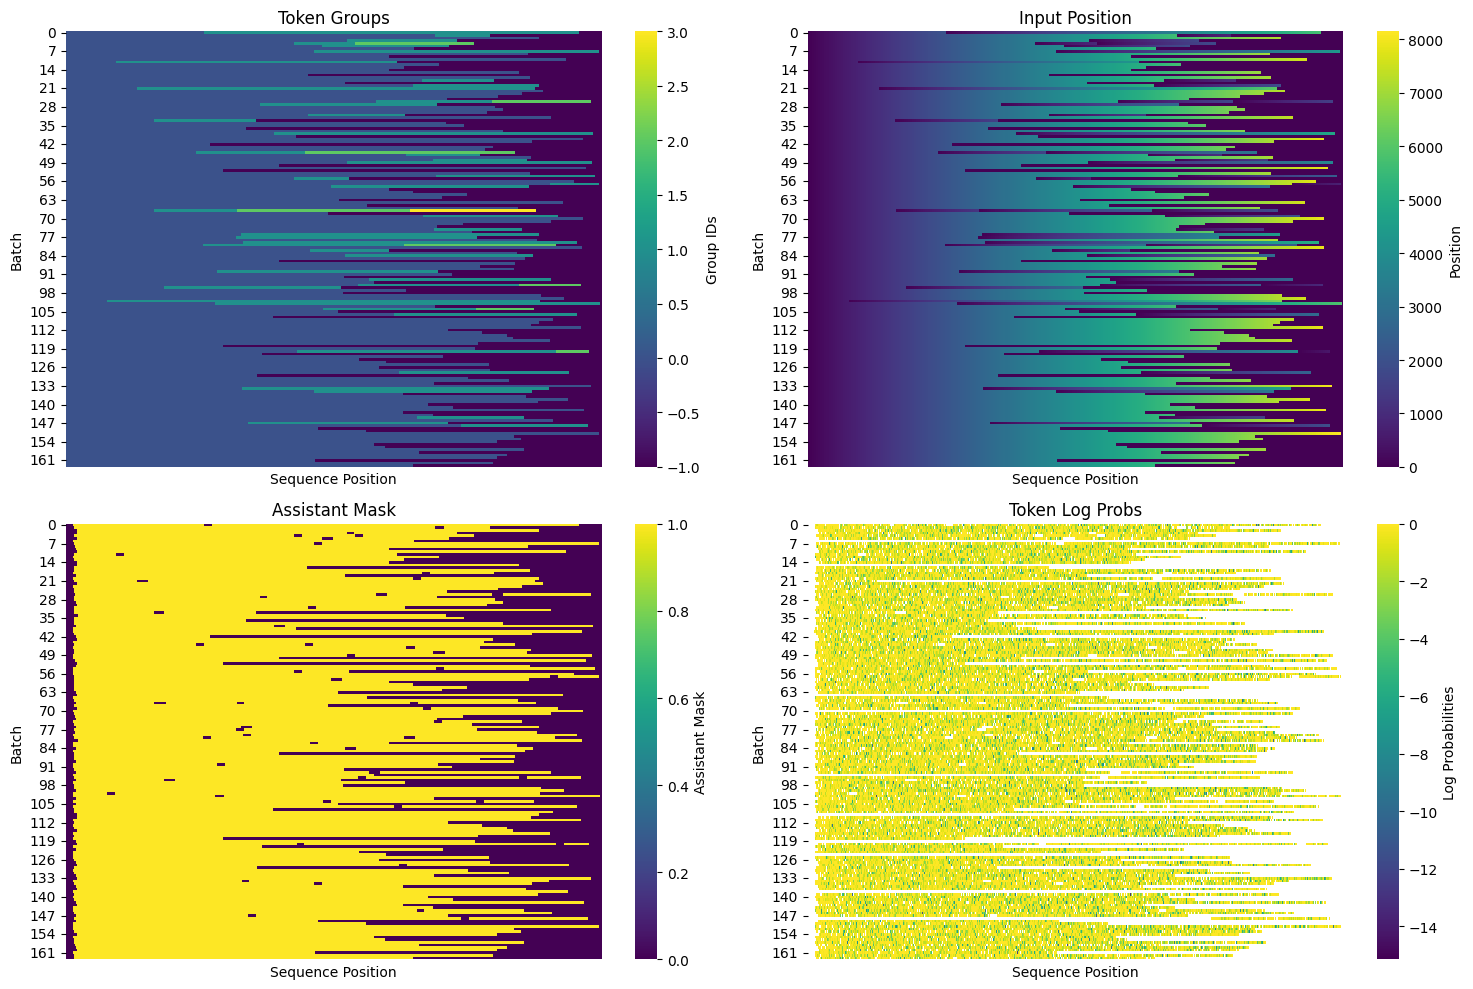

{'tokens': tensor([[128000, 128011,  10086,  ..., 128001, 128001, 128001],
         [128000, 128011,   2878,  ..., 128001, 128001, 128001],
         [128000, 128011,   2028,  ..., 128001, 128001, 128001],
         ...,
         [128000, 128011,  10086,  ..., 128001, 128001, 128001],
         [128000, 128011,  10086,  ..., 128001, 128001, 128001],
         [128000, 128011,   2878,  ..., 128001, 128001, 128001]]),
 'group_ids': tensor([[ 0,  0,  0,  ..., -1, -1, -1],
         [ 0,  0,  0,  ..., -1, -1, -1],
         [ 0,  0,  0,  ..., -1, -1, -1],
         ...,
         [ 0,  0,  0,  ..., -1, -1, -1],
         [ 0,  0,  0,  ..., -1, -1, -1],
         [ 0,  0,  0,  ..., -1, -1, -1]]),
 'input_pos': tensor([[0, 1, 2,  ..., 0, 0, 0],
         [0, 1, 2,  ..., 0, 0, 0],
         [0, 1, 2,  ..., 0, 0, 0],
         ...,
         [0, 1, 2,  ..., 0, 0, 0],
         [0, 1, 2,  ..., 0, 0, 0],
         [0, 1, 2,  ..., 0, 0, 0]]),
 'assistant_mask': tensor([[False, False, False,  ..., False, False, F

In [9]:
seq_len = 8192
packed_tensors = packed_tensors_from_tokenized_results(
    tokenized_results,
    seq_len=seq_len,
    pad_token_id=tokenizer.pad_token_id,  # type: ignore
)
plot_packed_tensors(packed_tensors)
packed_tensors

In [12]:
from lib.models import Model
from torchtune.models.qwen2_5 import qwen2_5_7b_base, qwen2_5_14b_base, qwen2_5_32b_base
from torchtune.models.llama3_1 import llama3_1_70b

# 1 H100
model = Model(
    base_model="deepseek-ai/DeepSeek-R1-Distill-Qwen-7B",
    tune_model=qwen2_5_7b_base,
    tune_model_type="QWEN2",
    tune_max_batch_tokens=49152,
    tune_optimizer=ComponentConfig(
        "torch.optim.AdamW",
        lr=2e-5,
        fused=True,
    ),
    vllm_named_arguments={},
)
# 2 H100s
model = Model(
    base_model="deepseek-ai/DeepSeek-R1-Distill-Qwen-14B",
    tune_model=qwen2_5_14b_base,
    tune_model_type="QWEN2",
    tune_max_batch_tokens=24576,
    tune_optimizer=ComponentConfig(
        "torchao.prototype.low_bit_optim.AdamW8bit",
        lr=2e-5,
    ),
    vllm_named_arguments={},
)
# 4 H100s
model = Model(
    base_model="deepseek-ai/DeepSeek-R1-Distill-Qwen-32B",
    tune_model=qwen2_5_32b_base,
    tune_model_type="QWEN2",
    tune_max_batch_tokens=65536,
    tune_optimizer=ComponentConfig(
        "torch.optim.AdamW",
        lr=2e-5,
        fused=True,
    ),
    vllm_named_arguments={},
    tune_fsdp_cpu_offload=True,
)
# 8 A100-80GB
model = Model(
    base_model="deepseek-ai/DeepSeek-R1-Distill-Llama-70B",
    tune_model=llama3_1_70b,
    tune_model_type="LLAMA3",
    tune_max_batch_tokens=16384,
    tune_optimizer=ComponentConfig(
        "torch.optim.AdamW",
        lr=2e-5,
        fused=True,
    ),
    vllm_named_arguments={},
    tune_fsdp_cpu_offload=False,
)

In [ ]:
distilled_model = await tune(
    base_model=model.base_model,
    output_dir="./models/rl1",
    packed_tensors=packed_tensors,
    model=model.tune_model,
    model_type=model.tune_model_type,
    config=TuneRecipeConfig(
        optimizer=model.tune_optimizer,
        batch_size=model.tune_max_batch_tokens // seq_len,
        fsdp_cpu_offload=model.tune_fsdp_cpu_offload,
        enable_activation_checkpointing=True,
        enable_activation_offloading=True,
        # custom_sharded_layers=["tok_embeddings", "output"],
        num_output_chunks=8,
    ),
)

/home/ubuntu/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Llama-70B/snapshots/0d6d11a6ea1187363aa7b78543f824fc02e06b14
$ tune run --nproc-per-node=8 lib.recipe.TuneRecipe --config ./models/rl1/config.yaml
Running with torchrun...


W0218 00:24:43.278000 48669 torch/distributed/run.py:793] 
W0218 00:24:43.278000 48669 torch/distributed/run.py:793] *****************************************
W0218 00:24:43.278000 48669 torch/distributed/run.py:793] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
W0218 00:24:43.278000 48669 torch/distributed/run.py:793] *****************************************
INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 30
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: /home/ubuntu/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Llama-70B/snapshots/0d6d11a6ea1187363aa7b78543f824fc02e06b14
  checkpoint_files:
  - /home/ubuntu/.cache/hug

Writing logs to models/rl1/logs/log_1739838295.txt


INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 30
INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 30
INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 30
INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 30
INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 30
INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 191.89 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 2.26 GiB
	GPU peak memory reserved: 2.36 GiB
	GPU peak memory active: 2.26 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': Fal

In [82]:
vllm = await start_vllm(
    model.base_model,
    # env={"VLLM_ALLOW_LONG_MAX_MODEL_LEN": "1"},
    max_concurrent_requests=512,
    named_arguments=dict(
        block_size=32,
        disable_log_requests=True,
        # enable_chunked_prefill=True,
        enable_prefix_caching=True,
        enforce_eager=True,
        gpu_memory_utilization=0.95,
        max_model_len=16384,
        max_num_seqs=512,
        max_num_batched_tokens=16384,
        num_scheduler_steps=8,
        preemption_mode="swap",
        return_tokens_as_token_ids=True,
        swap_space=80,
        tensor_parallel_size=torch.cuda.device_count(),
    ),
    timeout=120 + 15 * torch.cuda.device_count(),
)
vllm

$ vllm serve deepseek-ai/DeepSeek-R1-Distill-Qwen-32B --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=512 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=4 --port=8000 --api-key=default
INFO 02-17 22:21:06 __init__.py:190] Automatically detected platform cuda.
INFO 02-17 22:21:07 api_server.py:840] vLLM API server version 0.7.2
INFO 02-17 22:21:07 api_server.py:841] args: Namespace(subparser='serve', model_tag='deepseek-ai/DeepSeek-R1-Distill-Qwen-32B', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=None, chat_template_content_format='auto', response_role='assistant', ssl_keyfile=None, ssl_certfile=None, ssl_ca_certs

Loading safetensors checkpoint shards:   0% Completed | 0/8 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  12% Completed | 1/8 [00:00<00:04,  1.50it/s]
Loading safetensors checkpoint shards:  25% Completed | 2/8 [00:01<00:04,  1.44it/s]
Loading safetensors checkpoint shards:  38% Completed | 3/8 [00:02<00:03,  1.42it/s]
Loading safetensors checkpoint shards:  50% Completed | 4/8 [00:02<00:02,  1.42it/s]
Loading safetensors checkpoint shards:  62% Completed | 5/8 [00:03<00:02,  1.46it/s]
Loading safetensors checkpoint shards:  75% Completed | 6/8 [00:04<00:01,  1.43it/s]
Loading safetensors checkpoint shards:  88% Completed | 7/8 [00:04<00:00,  1.42it/s]
Loading safetensors checkpoint shards: 100% Completed | 8/8 [00:05<00:00,  1.72it/s]
Loading safetensors checkpoint shards: 100% Completed | 8/8 [00:05<00:00,  1.54it/s]



INFO 02-17 22:21:31 model_runner.py:1115] Loading model weights took 15.4137 GB
(VllmWorkerProcess pid=76907) INFO 02-17 22:21:31 model_runner.py:1115] Loading model weights took 15.4137 GB
(VllmWorkerProcess pid=76906) INFO 02-17 22:21:31 model_runner.py:1115] Loading model weights took 15.4137 GB
(VllmWorkerProcess pid=76905) INFO 02-17 22:21:31 model_runner.py:1115] Loading model weights took 15.4137 GB
(VllmWorkerProcess pid=76906) INFO 02-17 22:21:36 worker.py:267] Memory profiling takes 4.03 seconds
(VllmWorkerProcess pid=76906) INFO 02-17 22:21:36 worker.py:267] the current vLLM instance can use total_gpu_memory (79.11GiB) x gpu_memory_utilization (0.95) = 75.15GiB
(VllmWorkerProcess pid=76906) INFO 02-17 22:21:36 worker.py:267] model weights take 15.41GiB; non_torch_memory takes 4.13GiB; PyTorch activation peak memory takes 1.45GiB; the rest of the memory reserved for KV Cache is 54.16GiB.
(VllmWorkerProcess pid=76907) INFO 02-17 22:21:36 worker.py:267] Memory profiling takes 3

INFO:     Started server process [76471]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-17 22:22:41 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:48490 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


vLLM(client=<openai.AsyncOpenAI object at 0x75b67ef92210>, max_concurrent_tokens=850001, process=<Process 76471>)

In [83]:
import asyncio

tokenized_results = [
    result
    for results in await get_task_results(
        tasks=train_tasks[: 512 // 16],
        client=vllm.client,
        model=model.base_model,
        cache=False,
        log_results=8,
        n=16,
        params=ChatCompletionParams(
            stream_options={
                "include_usage": True,
            },
        ),
        semaphore=asyncio.Semaphore(vllm.max_concurrent_tokens // 3800),
        transform=TaskResultTokenizer(tokenizer),
    )
    for result in results
]

  0%|          | 0/512 [00:00<?, ?it/s]

In [30]:
vllm.process.terminate()
kill_vllm_workers()

In [40]:
vllm.max_concurrent_tokens // 3800

223

In [78]:
import asyncio
from typing import Any, Callable, Awaitable

create = vllm.client.chat.completions.create

class Semaphore:
    def __init__(self, fn: Callable[..., Awaitable], n: int) -> None:
        self.fn = fn
        self.semaphore = asyncio.Semaphore(n)
        setattr(fn.__self__, fn.__name__, self)
        
    async def __call__(self, *args: Any, **kwargs: Any) -> Any:
        print("acquiring semaphore")
        await self.semaphore.acquire()
        try:
            return await self.fn(*args, **kwargs)
        finally:
            self.semaphore.release()


Semaphore(create, vllm.max_concurrent_tokens // 3800)
vllm.client.chat.completions.create

In [73]:
vllm.client.chat.completions.create

In [80]:
await vllm.client.chat.completions.create(
    messages=[{"role": "user", "content": "Hello, world!"}], model=model.base_model, stream=True
)

acquiring semaphore


In [76]:
vllm.client.chat.completions.create = create

In [77]:
vllm.client.chat.completions.create

<bound method AsyncCompletions.create of <openai.resources.chat.completions.AsyncCompletions object at 0x75b1e122ab40>>

In [8]:
tokenizer = AutoTokenizer.from_pretrained(model.base_model)

In [15]:
tokenized_results = [
    result
    for results in await get_task_results(
        tasks=train_tasks[: 512 // 16],
        client=vllm.client,
        model=model.base_model,
        cache=False,
        log_results=8,
        n=16,
        params=ChatCompletionParams(
            stream_options={
                "include_usage": True,
            },
        ),
        transform=TaskResultTokenizer(tokenizer),
    )
    for result in results
]

  0%|          | 0/512 [00:00<?, ?it/s]

In [18]:
kill_vllm_workers()

In [17]:
del vllm

Final mask shape: torch.Size([63, 8192, 8192])


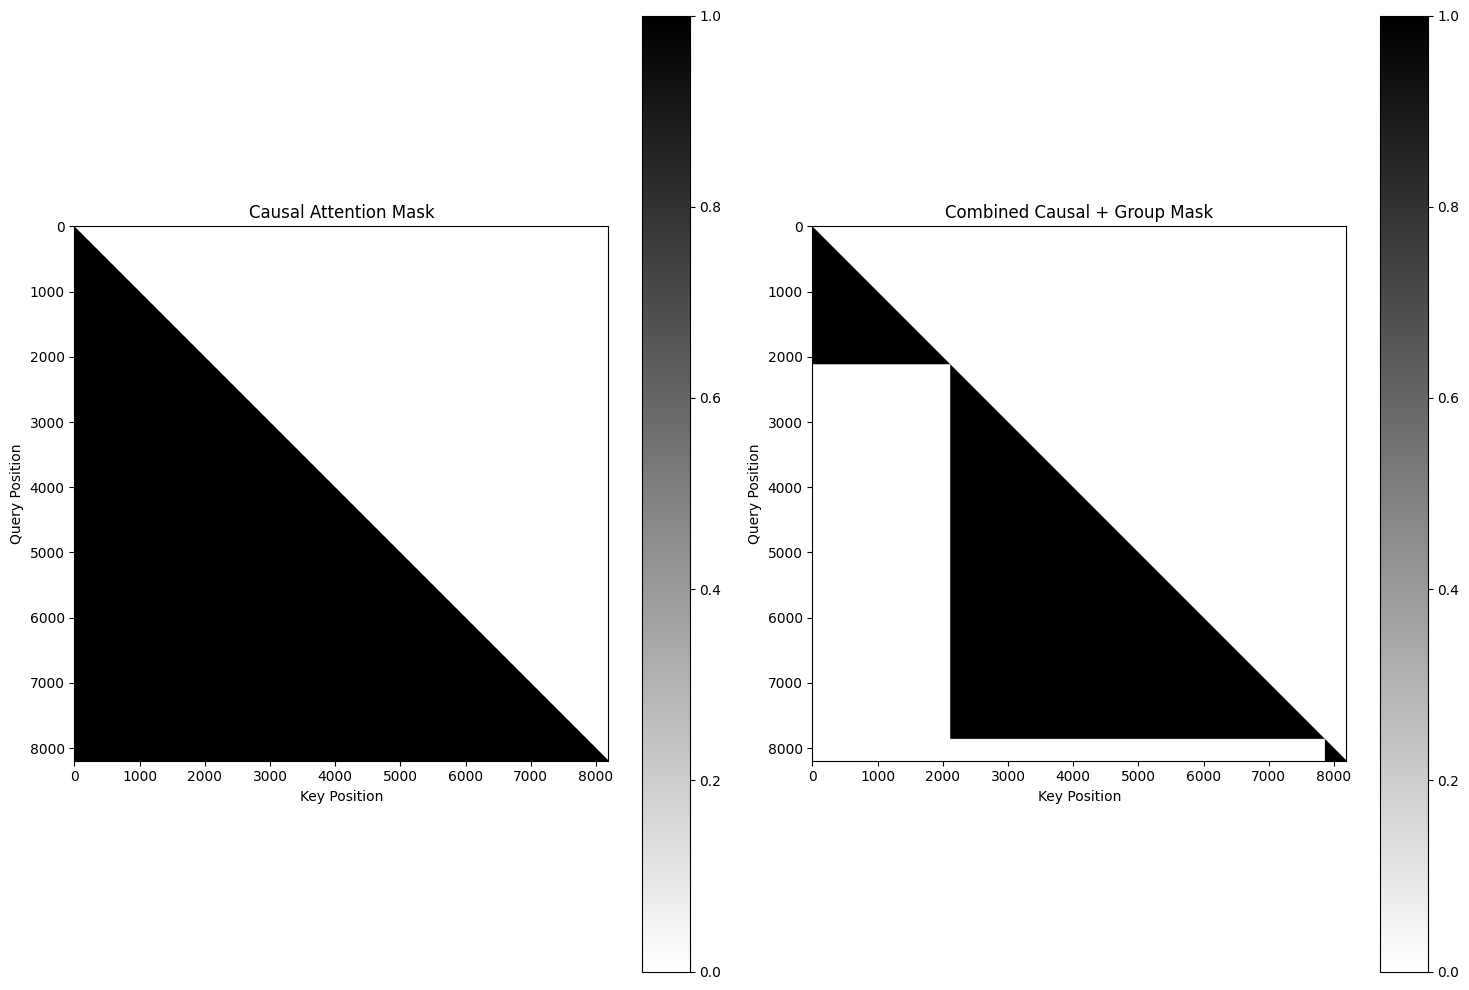

Mask shape: torch.Size([63, 8192, 8192])
Number of allowed attention connections (True values): 1263707944
Percentage of allowed connections: 29.9%


In [10]:
import torch

shape = packed_tensors["tokens"].shape

# Create causal attention mask for the batch size and sequence length
batch_size = shape[0]
seq_length = shape[1]

causal_mask = (
    torch.tril(torch.ones(seq_length, seq_length, dtype=torch.bool))
    .unsqueeze(0)
    .expand(batch_size, seq_length, seq_length)
)
group_mask = packed_tensors["group_ids"].unsqueeze(2) == packed_tensors[
    "group_ids"
].unsqueeze(1)
final_mask = causal_mask & group_mask

# Verify mask shape matches batch size and sequence length
print(f"Final mask shape: {final_mask.shape}")

# Visualize the combined attention mask
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10))

# Plot causal mask
mask_example = causal_mask[0].cpu().numpy()
im1 = ax1.imshow(mask_example, cmap="binary")
ax1.set_title("Causal Attention Mask")
ax1.set_xlabel("Key Position")
ax1.set_ylabel("Query Position")
plt.colorbar(im1, ax=ax1)

# Plot combined mask
final_mask_example = final_mask[0].cpu().numpy()
im2 = ax2.imshow(final_mask_example, cmap="binary")
ax2.set_title("Combined Causal + Group Mask")
ax2.set_xlabel("Key Position")
ax2.set_ylabel("Query Position")
plt.colorbar(im2, ax=ax2)

plt.tight_layout()
plt.show()

# Print some statistics
print(f"Mask shape: {final_mask.shape}")
print(
    f"Number of allowed attention connections (True values): {final_mask.sum().item()}"
)
print(
    f"Percentage of allowed connections: {final_mask.sum().item() / (final_mask.numel()) * 100:.1f}%"
)